In [22]:
from dask.distributed import Client
import multiprocessing

ncpu = multiprocessing.cpu_count()
threads = 8
nworker = ncpu // threads
print(
    f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}"
)

Number of CPUs: 48, number of threads: 8, number of workers: 6


In [23]:
client = Client(
    processes=True, threads_per_worker=threads, n_workers=nworker, memory_limit="256GB"
)
client

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:45123 Dashboard: http://127.0.0.1:42632/status,Cluster Workers: 6 Cores: 48 Memory: 386.55 GB


In [24]:
redo_ta = True
redo_clw = True
redo_cli = True

# Read prw files

In [25]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import metcalc
import scipy.stats as stat
import metpy
import pandas as pd

In [26]:
print("xarray Version: " + str(xr.__version__))

xarray Version: 0.15.1


In [27]:
# we can preprocess the data with the preproc function
# especially important is the assignment of a newcoordinate that 
# describes which ensemble member is meant
def preproc(ds):
    filename = ds.encoding['source']
    member=filename[36:43]
    #member is always at the same place in the filename, as long as the data is not moved
    ds = ds.squeeze(drop='true')
    ds['member'] = member
    return ds



data_prw=xr.open_mfdataset('../data/icon-param-exp/ppk00??_prw_remap63_1979-2014_mm.nc'
                       ,concat_dim='member', parallel=True, preprocess=preproc)



/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  from ipykernel import kernelapp as app
/home/mpim/m300577/.local/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


In [28]:
def correct_time(ds) :
    '''time stamps in ICON are wrong, we need to move the months one back.'''
    ds = ds.sel(time=slice(19790201,20150101))
    ds['time'] = pd.date_range(start='1/1979', end='01/2015', freq='M')
    return ds

In [29]:
data_prw_corr= correct_time(data_prw)
data_prw = data_prw_corr.resample(time='Y').mean().assign_coords(time=np.arange(1979.,2015.))
data_prw = data_prw.chunk({'time': -1})
data_prw_tm = data_prw.mean('time')

In [30]:
data_prw_tm.persist()

,Array,Chunk
Bytes,3.98 MB,73.73 kB
Shape,"(54, 96, 192)","(1, 96, 192)"
Count,54 Tasks,54 Chunks
Type,float32,numpy.ndarray


# strategy: 
 0. make a timemean
 1. sort the liquid water path for every simulation
 2. create a mask for every model based on moist and dry regions
 3. write that mask as output to netcdf? (one mask for every model)
 4. then the mask can be used by cdo, but we also do the calculation here with xarray with different variables


## Set lat bound and percentile

In [31]:
lat_bnd = 20
lower_percentile=0.1

In [32]:
prw_tropics =data_prw_tm.sel(lat=slice(lat_bnd,-lat_bnd)).squeeze(drop=True)

In [33]:
prw_tropics = prw_tropics.compute()
prw_tropics

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 192, member: 54)
Coordinates:
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * member   (member) object 'ppk0002' 'ppk0010' ... 'ppk0073' 'ppk0074'
  * lat      (lat) float64 19.59 17.72 15.85 13.99 ... -15.85 -17.72 -19.59
Data variables:
    prw      (member, lat, lon) float32 17.044153 15.633309 ... 20.081564

# Calculate PRW percentiles

## set percentile

In [34]:
upper_percentile = 1. - lower_percentile

lower_percentile_percent = round(lower_percentile * 100.)
upper_percentile_percent = round(upper_percentile * 100.)
upper_percentile_percent

90

In [35]:

prw_tropics['quantile_upper_value']=prw_tropics.quantile(q=upper_percentile,dim=('lat','lon')).prw
prw_tropics['quantile_lower_value']=prw_tropics.quantile(q=lower_percentile,dim=('lat','lon')).prw


In [36]:

mask_upper = xr.where( prw_tropics > prw_tropics.quantile_upper_value  , 1, 0)
mask_lower = xr.where( prw_tropics < prw_tropics.quantile_lower_value  , 1, 0)
# add attributes with model_id etc
mask_upper.attrs=prw_tropics.attrs
mask_lower.attrs=prw_tropics.attrs


In [37]:
mask_upper.load()

<xarray.Dataset>
Dimensions:               (lat: 22, lon: 192, member: 54)
Coordinates:
  * lon                   (lon) float64 0.0 1.875 3.75 ... 354.4 356.2 358.1
  * member                (member) object 'ppk0002' 'ppk0010' ... 'ppk0074'
  * lat                   (lat) float64 19.59 17.72 15.85 ... -17.72 -19.59
    quantile              float64 0.9
Data variables:
    prw                   (member, lat, lon) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    quantile_upper_value  (member) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    quantile_lower_value  (member) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

In [38]:
for member in mask_lower.member :
    model_name = member.values
    FILENAME = '../data/icon-param-exp/' + str(model_name) + '_prw_mask_lat' + str(lat_bnd) +'_dry_' + str(lower_percentile_percent) + '.nc'
    print(FILENAME)
    mask_lower.sel(member=member).to_netcdf(path=FILENAME , mode='w')


for member in mask_upper.member :
    model_name = member.values
    FILENAME = '../data/icon-param-exp/' + str(model_name) + '_prw_mask_lat' + str(lat_bnd) +'_wet_' + str(upper_percentile_percent) + '.nc'
    print(FILENAME)
    mask_upper.sel(member=member).to_netcdf(path=FILENAME , mode='w')



/work/mh0066/m300577/icon-param-exp/ppk0002_prw_mask_lat20_dry_10.nc
/work/mh0066/m300577/icon-param-exp/ppk0010_prw_mask_lat20_dry_10.nc
/work/mh0066/m300577/icon-param-exp/ppk0011_prw_mask_lat20_dry_10.nc
/work/mh0066/m300577/icon-param-exp/ppk0012_prw_mask_lat20_dry_10.nc
/work/mh0066/m300577/icon-param-exp/ppk0013_prw_mask_lat20_dry_10.nc
/work/mh0066/m300577/icon-param-exp/ppk0014_prw_mask_lat20_dry_10.nc
/work/mh0066/m300577/icon-param-exp/ppk0015_prw_mask_lat20_dry_10.nc
/work/mh0066/m300577/icon-param-exp/ppk0016_prw_mask_lat20_dry_10.nc
/work/mh0066/m300577/icon-param-exp/ppk0017_prw_mask_lat20_dry_10.nc
/work/mh0066/m300577/icon-param-exp/ppk0018_prw_mask_lat20_dry_10.nc
/work/mh0066/m300577/icon-param-exp/ppk0019_prw_mask_lat20_dry_10.nc
/work/mh0066/m300577/icon-param-exp/ppk0022_prw_mask_lat20_dry_10.nc
/work/mh0066/m300577/icon-param-exp/ppk0023_prw_mask_lat20_dry_10.nc
/work/mh0066/m300577/icon-param-exp/ppk0024_prw_mask_lat20_dry_10.nc
/work/mh0066/m300577/icon-param-ex

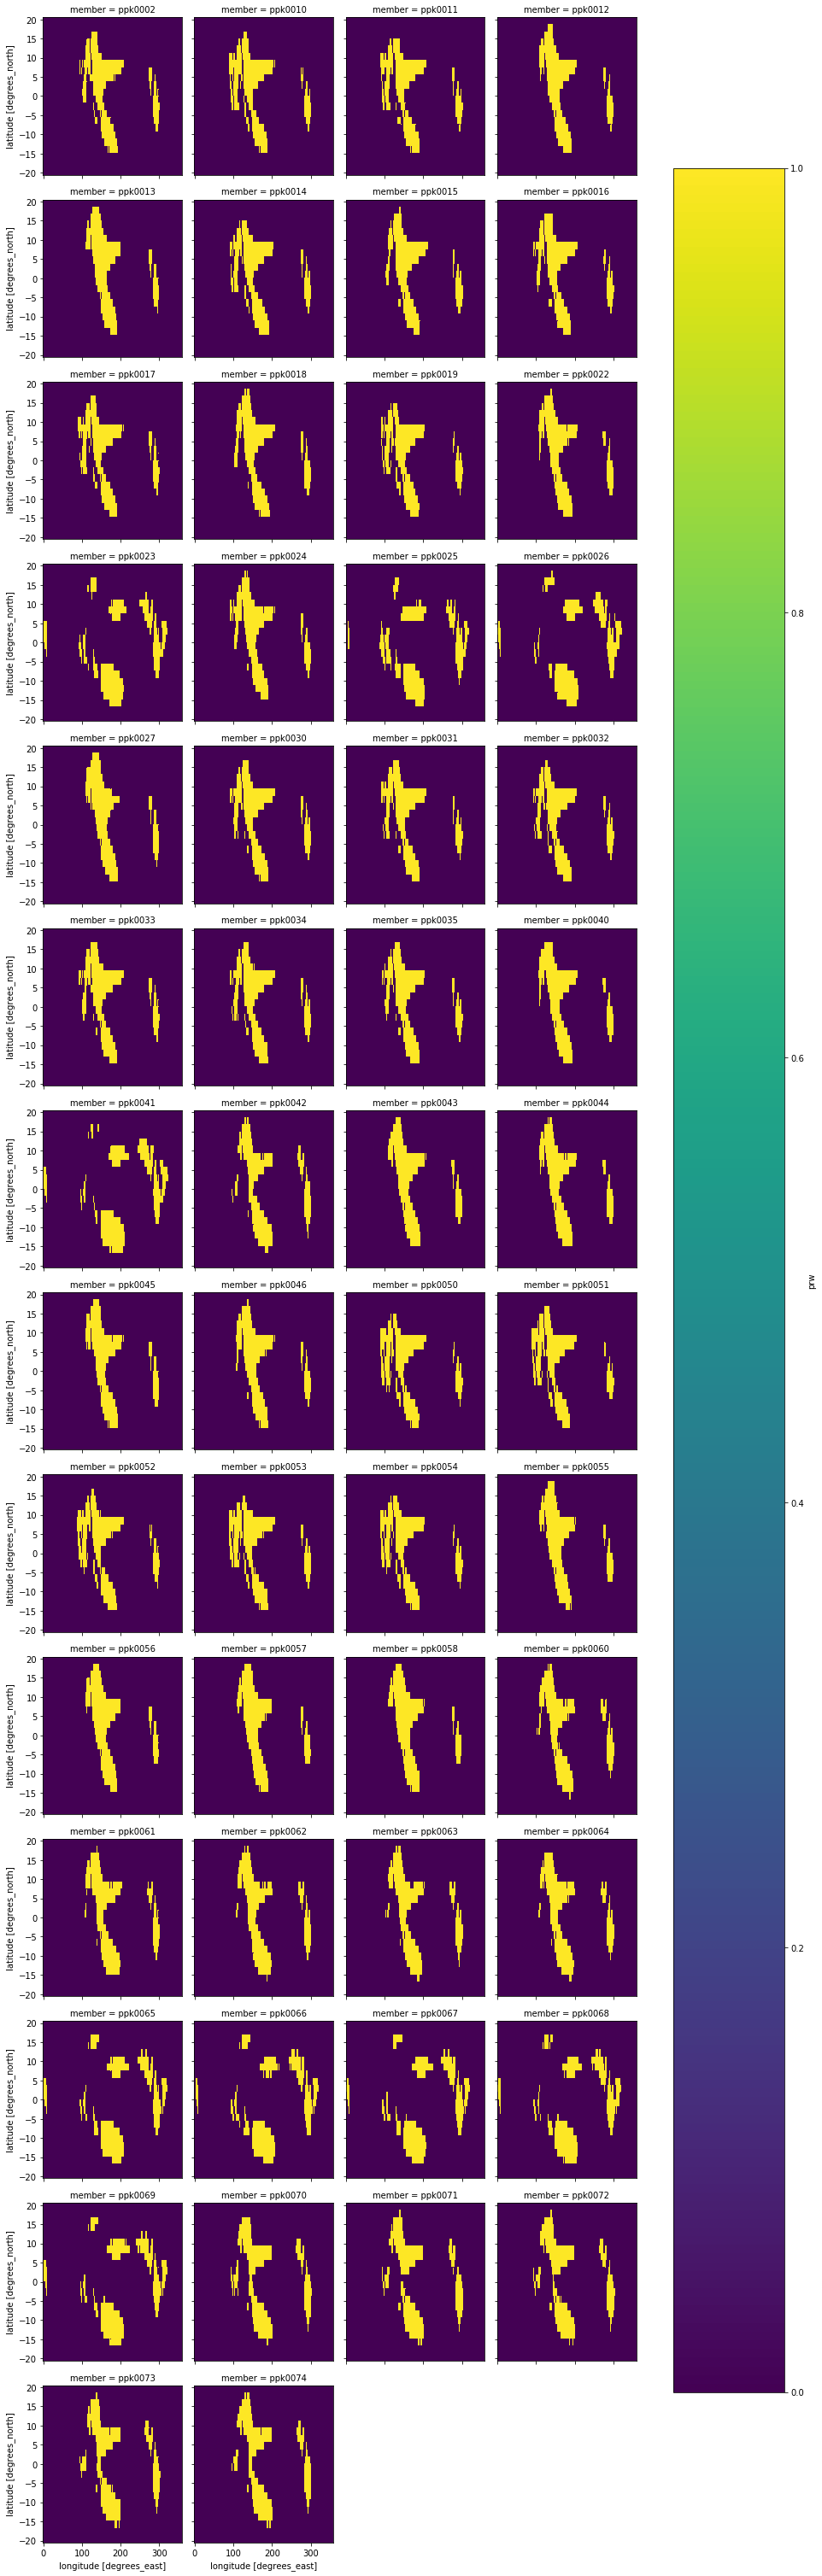

In [39]:
mask_upper.prw.plot(x='lon',y='lat',col='member', col_wrap=4)

For the continued calculation we want to have Nans instead of zeros for the mask:

In [44]:
mask_upper['prw'] = mask_upper['prw'].where( mask_upper['prw'] == 1)
mask_lower['prw'] = mask_lower['prw'].where( mask_lower['prw'] == 1)

# Calculate convecting regions

## Temperature 

In [20]:
def preproc_3d(ds):
    filename = ds.encoding['source']
    member=filename[36:43]
    ds = ds.squeeze(drop='true') 
    #member is always at the same place in the filename, as long as the data is not moved
    ds.coords['plev2'] = ds.plev / 100
    ds = ds.swap_dims({'plev': 'plev2'})
    ds.plev2['units'] = 'hPa'
    ds['member'] = member
    return ds



data_ta_mm=xr.open_mfdataset('../data/icon-param-exp/ppk00??_ta_remap63_1979-2014_mm.nc'
                       ,concat_dim='member', parallel=True, preprocess=preproc_3d)

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  from ipykernel import kernelapp as app
/home/mpim/m300577/.local/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the

In [21]:
data_ta_corr = correct_time(data_ta_mm)
data_ta = data_ta_corr.resample(time='Y').mean().assign_coords(time=np.arange(1979.,2015.))
data_ta = data_ta.chunk({'time': -1})

In [22]:
data_ta

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 192, member: 54, plev2: 15, time: 36)
Coordinates:
  * time     (time) float64 1.979e+03 1.98e+03 1.981e+03 ... 2.013e+03 2.014e+03
    plev     (plev2) float64 dask.array<chunksize=(15,), meta=np.ndarray>
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * member   (member) object 'ppk0002' 'ppk0010' ... 'ppk0073' 'ppk0074'
  * plev2    (plev2) float64 1e+03 850.0 700.0 600.0 ... 50.0 25.0 15.0 10.0
Data variables:
    pfull    (time, member, plev2, lat, lon) float32 dask.array<chunksize=(36, 1, 15, 96, 192), meta=np.ndarray>
    ta       (time, member, plev2, lat, lon) float32 dask.array<chunksize=(36, 1, 15, 96, 192), meta=np.ndarray>

In [23]:
data_ta_wet = metcalc.xr_fldmean(data_ta.sel(lat=slice(lat_bnd,-lat_bnd)) * mask_upper.prw)

averigin over latitude (lat) and lonigtude (lon)


In [24]:
if redo_ta == True :
    %time data_ta_wet = data_ta_wet.compute()
    data_ta_wet.to_netcdf(path='../icon-param-exp/all_ta_lat'
                      + str(lat_bnd) +'_wet_' + str(upper_percentile_percent) + 'prw_ym.nc'  , mode='w')

CPU times: user 38.2 s, sys: 3.29 s, total: 41.5 s
Wall time: 4min 39s


## Cloud Water and Ice

In [25]:
data_clw_mm=xr.open_mfdataset('../data/icon-param-exp/ppk00??_clw_remap63_1979-2014_mm.nc'
                       ,concat_dim='member', parallel=True, preprocess=preproc_3d)

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/mpim/m300577/.local/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


In [26]:
data_cli_mm=xr.open_mfdataset('../data/icon-param-exp/ppk00??_cli_remap63_1979-2014_mm.nc'
                       ,concat_dim='member', parallel=True, preprocess=preproc_3d)

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/mpim/m300577/.local/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


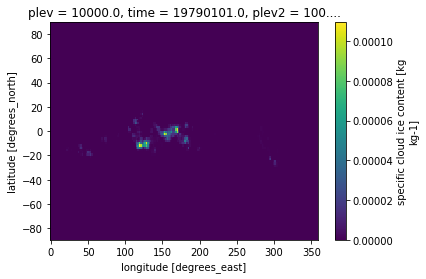

In [27]:
data_cli_mm.cli.isel(time=0,member=0,plev2=10).plot(x='lon',y='lat')

In [28]:
data_clw_corr = correct_time(data_clw_mm)
data_clw = data_clw_corr.resample(time='Y').mean().assign_coords(time=np.arange(1979.,2015.))
data_clw = data_clw.chunk({'time': -1})

In [29]:
data_cli_corr = correct_time(data_cli_mm)
data_cli = data_cli_corr.resample(time='Y').mean().assign_coords(time=np.arange(1979.,2015.))
data_cli = data_cli.chunk({'time': -1})

In [30]:
data_clw_wet = metcalc.xr_fldmean(data_clw.sel(lat=slice(lat_bnd,-lat_bnd)) * mask_upper.prw)

averigin over latitude (lat) and lonigtude (lon)


In [31]:
data_cli_wet = metcalc.xr_fldmean(data_cli.sel(lat=slice(lat_bnd,-lat_bnd)) * mask_upper.prw)

averigin over latitude (lat) and lonigtude (lon)


In [32]:
if redo_clw == True :
    %time data_clw_wet = data_clw_wet.compute()
    data_clw_wet.to_netcdf(path='../data/icon-param-exp/all_clw_lat'
                      + str(lat_bnd) +'_wet_' + str(upper_percentile_percent) + 'prw_ym.nc'  , mode='w')

CPU times: user 29.3 s, sys: 2.35 s, total: 31.6 s
Wall time: 2min 57s


In [33]:
if redo_cli == True :
    %time data_cli_wet = data_cli_wet.compute()
    data_cli_wet.to_netcdf(path='/../data/icon-param-exp/all_cli_lat'
                      + str(lat_bnd) +'_wet_' + str(upper_percentile_percent) + 'prw_ym.nc'  , mode='w')

CPU times: user 31.1 s, sys: 2.41 s, total: 33.5 s
Wall time: 3min 5s


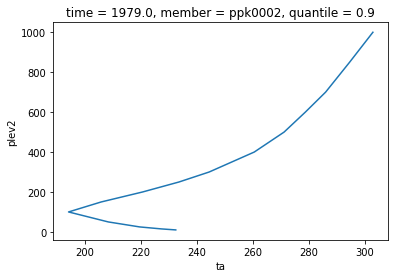

In [34]:
data_ta_wet.ta.isel(time=0,member=0).plot(y='plev2')